In [1]:
!pip install librosa


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import librosa
import numpy as np

**LOADING THE DATASET**

In [3]:
DATA_DIR = r"C:\Users\fastf\Downloads\snoring_dataset\Snoring Dataset"

In [4]:
print("Files in DATA_DIR:", os.listdir(DATA_DIR))

Files in DATA_DIR: ['0', '1', 'Snoring_dataset.txt']


**DATASET PREPROCESSING**

In [5]:
file_path = os.path.join(DATA_DIR, "0", os.listdir(os.path.join(DATA_DIR, "0"))[0])
audio, sr = librosa.load(file_path, sr=16000)
print(f"Loaded: {file_path}")
print(f"Audio Shape: {audio.shape}, Sampling Rate: {sr}")

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Loaded: C:\Users\fastf\Downloads\snoring_dataset\Snoring Dataset\0\0_0.wav
Audio Shape: (16000,), Sampling Rate: 16000


In [6]:
import numpy as np

X = []
y = []
for label in ["0", "1"]:
    folder = os.path.join(DATA_DIR, label)
    for filename in os.listdir(folder):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder, filename)
            audio, _ = librosa.load(file_path, sr=16000)
            X.append(audio)
            y.append(int(label)) 

X = np.array(X, dtype=object)
y = np.array(y)

print(f"Loaded {len(X)} audio samples")
print(f"Labels shape: {y.shape}")


Loaded 1000 audio samples
Labels shape: (1000,)


In [7]:
MAX_LEN = 1 * 16000 

def pad_or_trim(audio, max_len=MAX_LEN):
    if len(audio) > max_len:
        return audio[:max_len]  
    else:
        return np.pad(audio, (0, max_len - len(audio))) 

X_fixed = np.array([pad_or_trim(a) for a in X])
print(f"New shape: {X_fixed.shape}")


New shape: (1000, 16000)


**EXTRACT MFCC FEATURE**

In [8]:
def extract_mfcc(audio, sr=16000, n_mfcc=40):
 audio = audio.astype(np.float32)
 mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
 return mfcc.T  


X_mfcc = np.array([extract_mfcc(a) for a in X_fixed])
print(f"MFCCs shape: {X_mfcc.shape}")  


MFCCs shape: (1000, 32, 40)


**TRAIN TEST SPLIT**

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_mfcc, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (800, 32, 40), Test: (200, 32, 40)


**VISUALIZATION OF DATASET**

In [10]:
# Waveform of an audio file

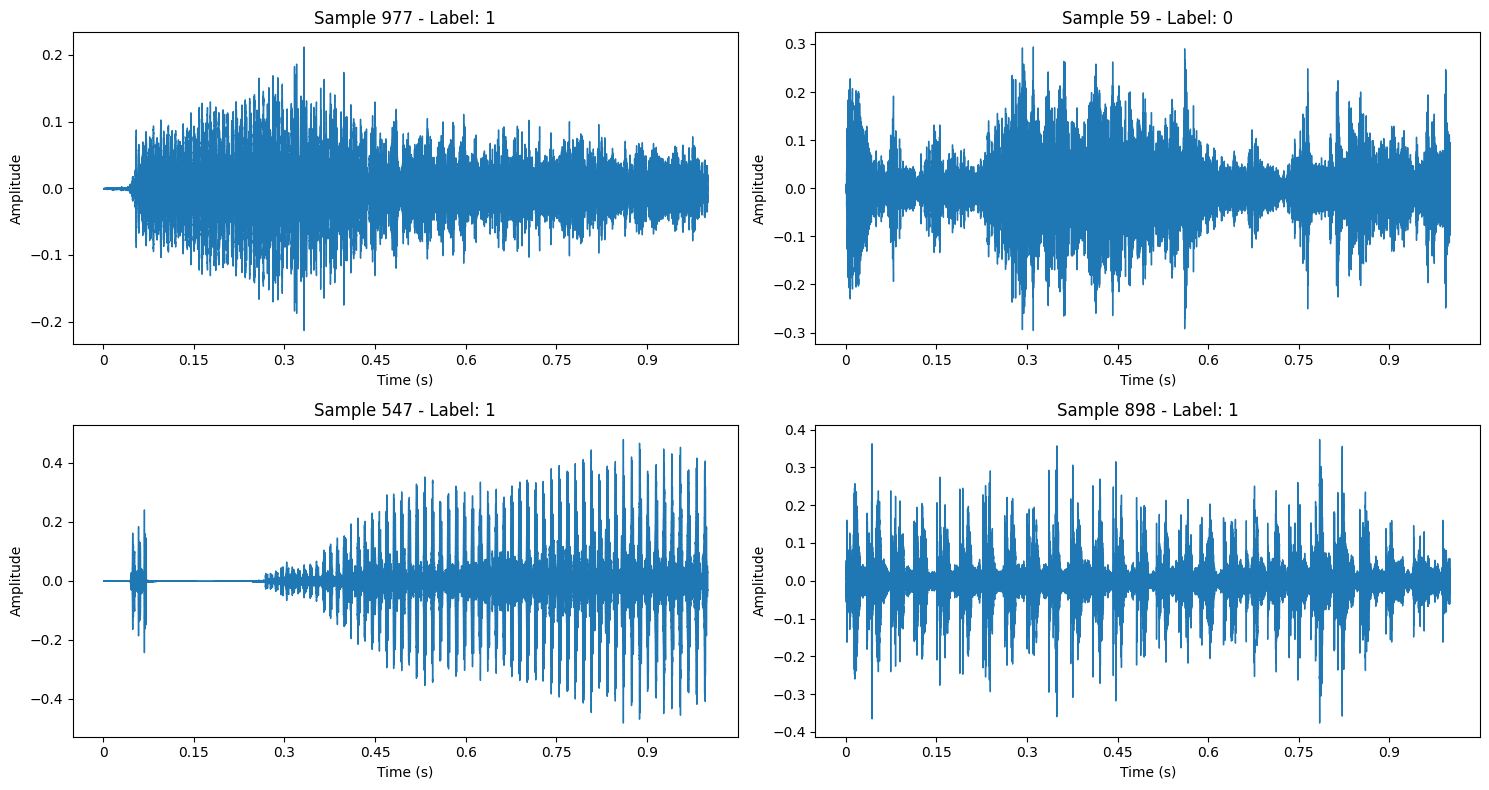

In [11]:
import random
import matplotlib.pyplot as plt
import librosa.display
import numpy as np


num_samples = 4


indices = random.sample(range(len(X_fixed)), num_samples)


plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    plt.subplot(2, 2, i+1)  
    
    
    audio = X_fixed[idx].astype(np.float32)
    librosa.display.waveshow(audio, sr=16000)
    
    plt.title(f"Sample {idx} - Label: {y[idx]}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [12]:
#MFCC VISUALIZATION

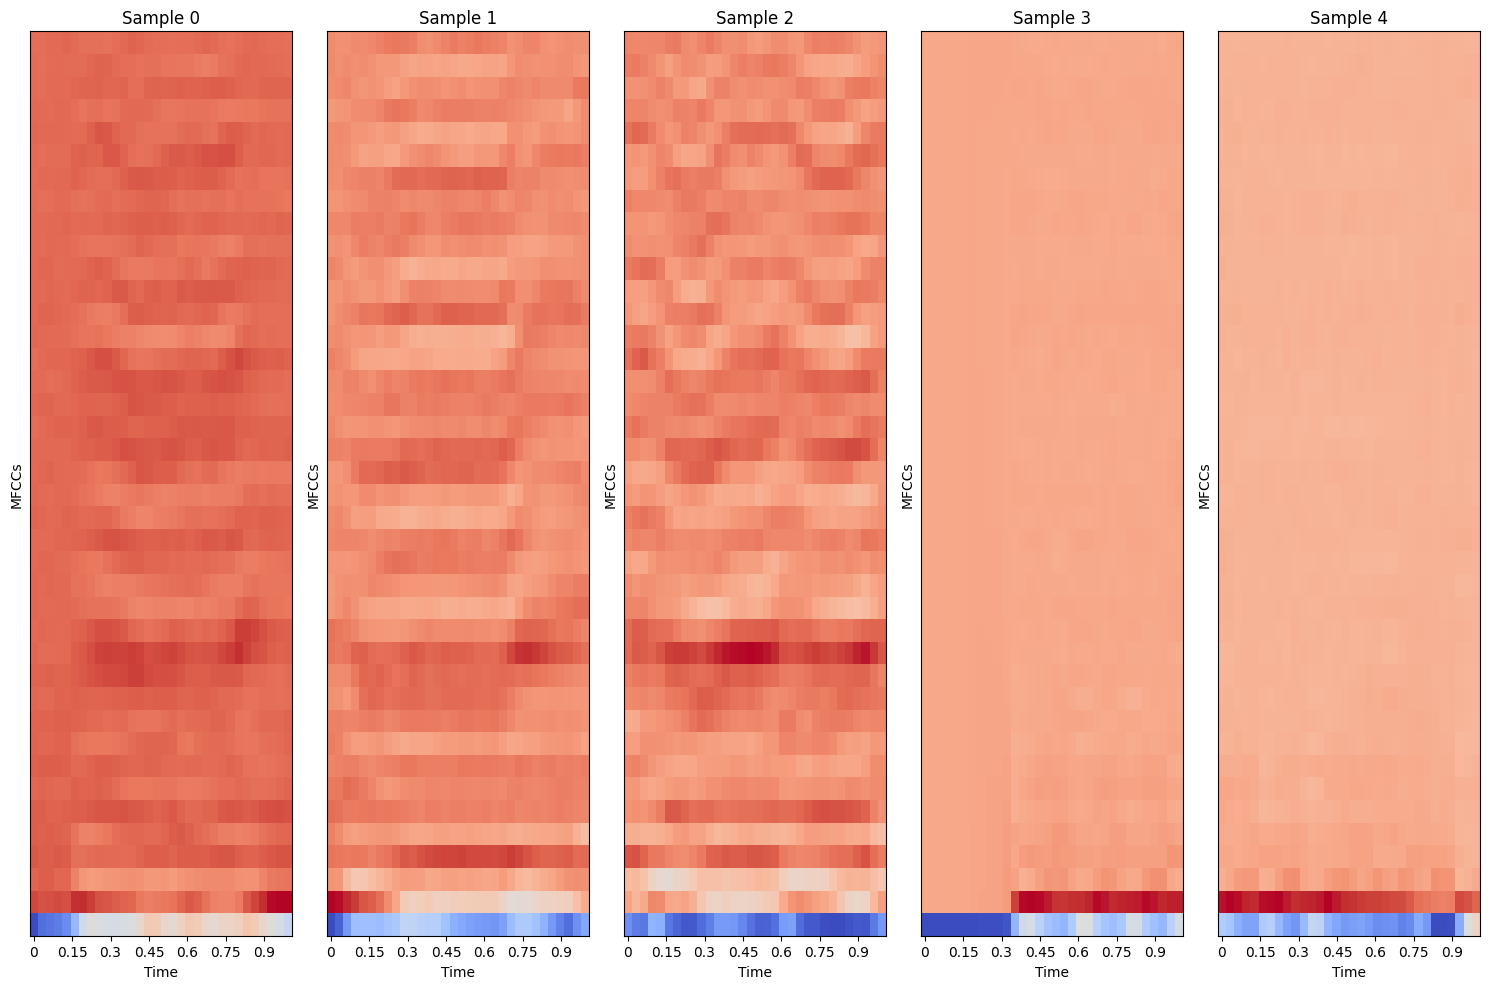

In [13]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np


num_samples_to_plot = 5
plt.figure(figsize=(15, 10))

for i in range(num_samples_to_plot):
    sample_audio = X_fixed[i].astype(np.float32)
    mfcc = librosa.feature.mfcc(y=sample_audio, sr=16000, n_mfcc=40)

    plt.subplot(1, num_samples_to_plot, i + 1)
    librosa.display.specshow(mfcc, x_axis='time', sr=16000)
    plt.title(f"Sample {i}")
    plt.xlabel("Time")
    plt.ylabel("MFCCs")

plt.tight_layout()
plt.show()


In [14]:
#Class distribution

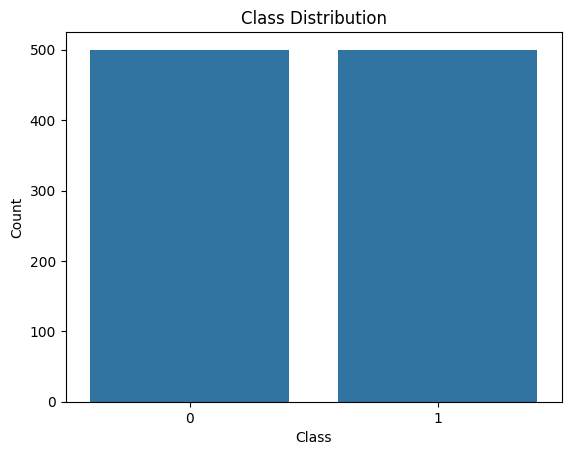

In [15]:
import seaborn as sns
import pandas as pd

sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


**MODEL BUILDING**

In [16]:
#Add channel dimension for CNN

In [17]:
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

print(f"Train shape: {X_train_cnn.shape}, Test shape: {X_test_cnn.shape}")


Train shape: (800, 32, 40, 1), Test shape: (200, 32, 40, 1)


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

input_shape = X_train_cnn.shape[1:]
num_classes = len(np.unique(y_train))  

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
])

loss_fn = 'sparse_categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy'

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model.summary()


C:\Users\fastf\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 38, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 38, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 17, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 17, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         393,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 412,802 (1.57 MB)

 Trainable params: 412,610 (1.57 MB)

 Non-trainable params: 192 (768.00 B)

In [19]:
#One hot encoding


In [20]:
from tensorflow.keras.utils import to_categorical
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


y_train shape: (800, 2), y_test shape: (200, 2)


In [21]:
history = model.fit(
    X_train_cnn, y_train,          
    validation_data=(X_test_cnn, y_test),  
    epochs=20,                     
    batch_size=32,                 
    verbose=1                     
)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7688 - loss: 0.8127 - val_accuracy: 0.8600 - val_loss: 0.3050
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9575 - loss: 0.1445 - val_accuracy: 0.8650 - val_loss: 0.3047
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9697 - loss: 0.0788 - val_accuracy: 0.8900 - val_loss: 0.2377
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9923 - loss: 0.0466 - val_accuracy: 0.9600 - val_loss: 0.1163
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9732 - loss: 0.0684 - val_accuracy: 0.9700 - val_loss: 0.0766
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9849 - loss: 0.0489 - val_accuracy: 0.9750 - val_loss: 0.0732
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9981 - loss: 0.0161 - val_accuracy: 0.9850 - val_loss: 0.0402
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9946 - loss: 0.0195 - val_accuracy: 0.9900 - v

**MODEL EVALUATION**

In [22]:
test_loss, test_acc = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9963 - loss: 0.0110   
Test Accuracy: 0.9950, Test Loss: 0.0148


In [23]:
#Accuracy plot

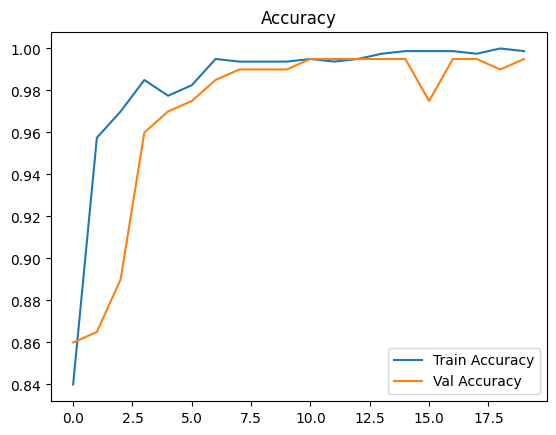

In [24]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [25]:
#Loss plot

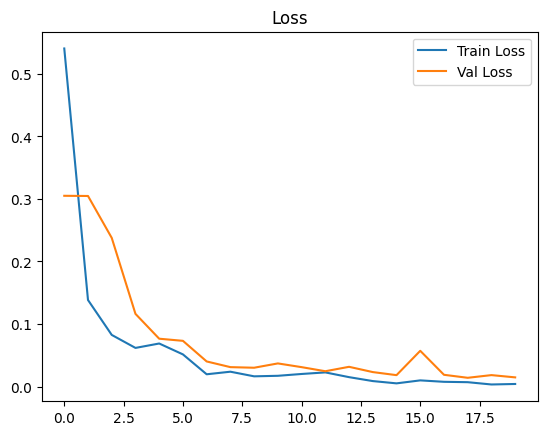

In [26]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [27]:
# Convert y_true from one-hot encoding to class labels
y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

print("True Labels:", y_true[:10])
print("Predicted Labels:", y_pred_classes[:10])



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True Labels: [1 1 1 1 0 1 1 1 1 0]
Predicted Labels: [1 1 1 1 0 1 1 1 1 0]


**VISUALIZATION OF TRAINED MODEL**

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<Figure size 600x600 with 0 Axes>

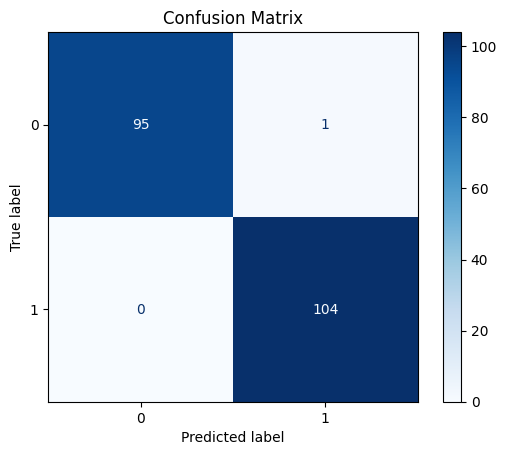

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [29]:
#Classification report

In [30]:
from sklearn.metrics import classification_report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        96
           1       0.99      1.00      1.00       104

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



**SAVE THE MODEL**

In [31]:
model.save("sleep_apnea_cnn_model.h5")


**PREDICTION ON NEW INPUT**

In [32]:
import librosa
import numpy as np

def predict_audio(file_path, model, sr=16000, n_mfcc=40, time_steps=32):
    
    
    audio, _ = librosa.load(file_path, sr=sr)

    
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    
    if mfcc.shape[1] < time_steps:
        pad_width = time_steps - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :time_steps]

    
    mfcc = mfcc.T  

    
    mfcc = mfcc[np.newaxis, ..., np.newaxis]  

    
    mfcc = mfcc.astype(np.float32)

    
    pred = model.predict(mfcc)
    predicted_class = np.argmax(pred, axis=1)[0]

    return predicted_class


file_path = r"C:\Users\fastf\Downloads\snoring_dataset\Snoring Dataset\0\0_9.wav"
print(predict_audio(file_path, model))







1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
0


In [33]:
import os

folder_path = r"C:\Users\fastf\Desktop\sleep apnea detection model"
os.makedirs(folder_path, exist_ok=True)

model.save(os.path.join(folder_path, "sleep_apnea_cnn_model.h5"))
